In [1]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcol
from matplotlib import font_manager

# settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
# load data
prod22 = pd.read_csv('Data/brewery_production_2022_melted.csv')

# remove total annual rows
prod22 = prod22[prod22['month'] != 'total_annual']
prod22.reset_index(inplace=True, drop=True)

In [3]:
# get breweries that opened in 2022
brew22 = prod22[prod22['year_established'] == 2022][['brewery']].drop_duplicates()['brewery'].tolist()
#brew22

# month of 2022 breweries
opening_month = {
    'Bizarre Brewing':10,
    'Byron Street Brewery':7,
    'Cursed Brewing':10,
    'Hildegard Ferments and Botanicals':10,
    'No Drought Brewing Company':1,
    'Peace of Mind Brewing':8,
    'Uprise Brewing Company':8,
    'Vice Beer':5,
    'Wild Oak Project':2,
    '45 Degree Brewhouse':6,
    'High Bluff Brewing':8,
    'Spokanite Brewing':6,
    'Top Knot Brewing':1,
    'Darach Brewing Company':12,
    'Common Language Brewing Company':4,
    'Griffin Brewing Pilot House':3,
    'New Maitland Brewing Llc':7
}

# input zeros for months prior to opening
months = {1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June',
         7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}

for k,v in opening_month.items():
    m = [value for key, value in months.items() if key < v]
    prod22['production'] = np.where((prod22['brewery'] == k) & (prod22['production'].isna()) & 
                                    (prod22['month'].isin(m)), 0, prod22['production'])

In [4]:
# check for consecutive nulls
prod22['is_null'] = prod22['production'].isnull().astype(int)
prod22['consec_nulls'] = prod22.groupby(['brewery', prod22['is_null'].eq(0).cumsum()])['is_null'].cumsum()
prod22['max_consec_nulls'] =  prod22.groupby(['brewery'])['consec_nulls'].transform(max)

In [5]:
# interpolate for breweries with 3 or fewer consecutive nulls
prod22['linear_interpolation'] = prod22.groupby('brewery')['production'].transform(
    lambda x: x.interpolate(method='linear', limit_direction='both')).reset_index()['production']

prod22['interpolated'] = np.where((prod22['max_consec_nulls'] <= 3) & (prod22['production'].isnull()), 1, 0)

prod22['production'] = np.round(
        np.where((prod22['max_consec_nulls'] <= 3) & (prod22['max_consec_nulls'] > 0),
            prod22['linear_interpolation'],
            prod22['production']), 2)

In [6]:
# calculate annual totals
cols = ['brewery','brewery_type','address', 'city','zipcode','county',
        'latitude','longitude','year_established','guild_member',
        'closed_since_2022','untappd_profile_link']

annuals1 = pd.DataFrame(prod22[prod22['max_consec_nulls'] <= 3].groupby(cols)['production'].sum().reset_index())

annuals2 = pd.DataFrame(prod22[prod22['max_consec_nulls'] > 3][cols]).drop_duplicates().reset_index(drop=True)
annuals2['production'] = np.NaN

annuals = pd.concat([annuals1, annuals2]).reset_index(drop=True)
annuals['month'] = 'total_annual'

# merge back into prod22
prod22 = pd.concat([prod22, annuals])

# set order
months = ['January','February','March','April','May','June','July',
        'August','September','October','November','December','total_annual']
prod22['month'] = pd.Categorical(prod22['month'], months)
prod22 = prod22.sort_values(by=['brewery', 'month']).reset_index(drop=True)

In [7]:
# clean up interpolated
prod22['interpolated'] = np.where(prod22['month'] == 'total_annual', 0, prod22['interpolated'])
prod22['interpolated'] = prod22['interpolated'].astype(int)
    
# drop unnecessary columns
cols_to_drop = ['is_null','consec_nulls','max_consec_nulls','linear_interpolation']
prod22.drop(columns=cols_to_drop, axis=1, inplace=True)

In [8]:
prod22.head()

,brewery,brewery_type,address,city,zipcode,county,latitude,longitude,year_established,guild_member,closed_since_2022,untappd_profile_link,month,production,interpolated
0,192 Brewing Company,brewpub,7324 NE 175th Street Ste F,Kenmore,98028,King,47.756677,-122.242502,2010,1,0,https://untappd.com/192BrewingCo,January,NaN,0
1,192 Brewing Company,brewpub,7324 NE 175th Street Ste F,Kenmore,98028,King,47.756677,-122.242502,2010,1,0,https://untappd.com/192BrewingCo,February,0.5,0
2,192 Brewing Company,brewpub,7324 NE 175th Street Ste F,Kenmore,98028,King,47.756677,-122.242502,2010,1,0,https://untappd.com/192BrewingCo,March,NaN,0
3,192 Brewing Company,brewpub,7324 NE 175th Street Ste F,Kenmore,98028,King,47.756677,-122.242502,2010,1,0,https://untappd.com/192BrewingCo,April,NaN,0
4,192 Brewing Company,brewpub,7324 NE 175th Street Ste F,Kenmore,98028,King,47.756677,-122.242502,2010,1,0,https://untappd.com/192BrewingCo,May,NaN,0


In [9]:
# pivot data
indexes = ['brewery','brewery_type','address','city','zipcode','county','latitude','longitude',
           'year_established','guild_member','closed_since_2022','untappd_profile_link']
prod22_pivot = prod22.pivot(index=indexes, columns='month', values='production').reset_index()

prod22_pivot.head()

month,brewery,brewery_type,address,city,zipcode,county,latitude,longitude,year_established,guild_member,closed_since_2022,untappd_profile_link,January,February,March,April,May,June,July,August,September,October,November,December,total_annual
0,192 Brewing Company,brewpub,7324 NE 175th Street Ste F,Kenmore,98028,King,47.756677,-122.242502,2010,1,0,https://untappd.com/192BrewingCo,NaN,0.50,NaN,NaN,NaN,NaN,NaN,0.33,NaN,NaN,NaN,NaN,NaN
1,20 Corners Brewing Company,brewpub,14148 NE 190th St - Suite A,Woodinville,98072,King,47.765067,-122.151015,2016,0,0,https://untappd.com/20CornersBrewingCompany,104.64,104.64,147.98,72.33,106.73,141.13,175.53,209.93,132.30,104.08,75.86,106.50,1481.65
2,23rd Ave Brewery,micro,2313 S Jackson St,Seattle,98144,King,47.599270,-122.301800,2018,0,0,https://untappd.com/23rdAveBrewery,NaN,NaN,NaN,NaN,2.00,4.78,5.00,NaN,1.00,14.00,NaN,NaN,NaN
3,4 Stitch Brewing Company,brewpub,16709 9th Ave SE,Mill Creek,98012,Snohomish,47.846174,-122.220188,2017,1,0,https://untappd.com/4StitchBrewingCompany,NaN,2.00,1.25,NaN,4.72,NaN,1.46,3.40,NaN,NaN,NaN,NaN,NaN
4,45 Degree Brewhouse,brewpub,10421 E Sprague Ave,Spokane Valley,99206,Spokane,47.657419,-117.264451,2022,0,0,https://untappd.com/w/45-degree-brewhouse/530239,0.00,0.00,0.00,0.00,0.00,1.77,3.54,5.32,7.09,15.10,23.12,31.13,87.07


In [10]:
# save data
prod22.to_csv('Data/brewery_production_2022_melted_interpolated.csv', index=False)
prod22_pivot.to_csv('Data/brewery_production_2022_interpolated.csv', index=False)

In [11]:
# set theme

# use lato font
font_path = 'Reference/Lato/Lato-Regular.ttf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()

# set colors
col_yellow = '#ffa400'
col_green = '#256143'
col_brown = '#9c5421'
col_off_black = '#434343'
mpl.rcParams['text.color'] = col_off_black # title and legend
mpl.rcParams['xtick.color'] = col_off_black # tick marks
mpl.rcParams['ytick.color'] = col_off_black # tick marks
mpl.rcParams['axes.labelcolor'] = col_off_black # axes labels

# set font sizes
mpl.rcParams['axes.titlesize'] = 13 # title
mpl.rcParams['axes.labelsize'] = 12 # axes labels
mpl.rcParams['xtick.labelsize'] = 11 # tick marks
mpl.rcParams['ytick.labelsize'] = 11 # tick marks
mpl.rcParams['legend.title_fontsize'] = 12 # legend title
mpl.rcParams['legend.fontsize'] = 11 # legend text

# figure sizes (horizontal/vertical/square)
figsize_v = (6,10)
figsize_h = (10,6)

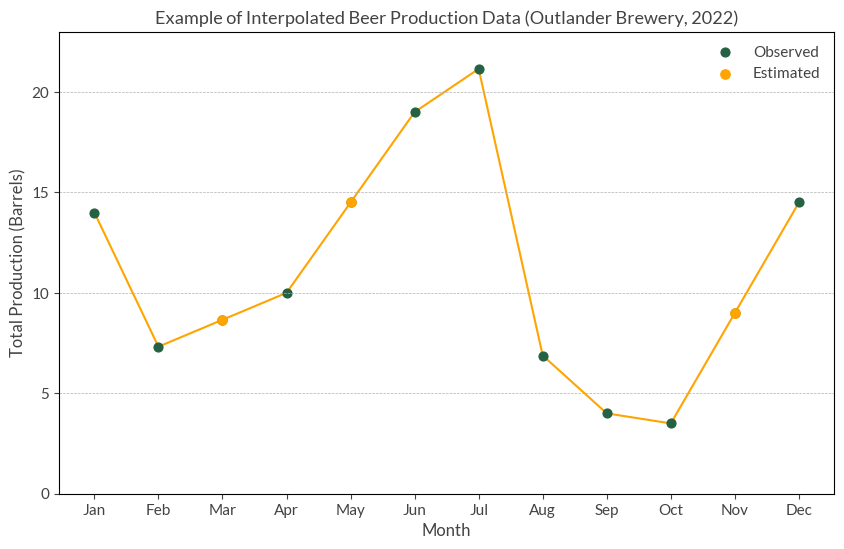

In [12]:
# make example viz for report and presentation

# data
outlander = prod22.loc[(prod22['brewery'] == 'Outlander Brewery and Pub') & (prod22['month'] != 'total_annual'), 
                       ['month', 'production', 'interpolated']].copy()

outlander['month_short'] = outlander['month'].apply(lambda x: x[:3])

outlander_est = outlander.loc[outlander['interpolated'] == 1, ['month_short', 'production']].copy()

# viz
plt.figure(figsize=figsize_h)

plt.scatter(x=outlander['month_short'], y=outlander['production'], c=col_green, s=40)
plt.scatter(x=outlander_est['month_short'], y=outlander_est['production'], c=col_yellow, s=45)
plt.plot(outlander['month_short'], outlander['production'], color=col_yellow, zorder=-1)

plt.legend(['Observed', 'Estimated'], frameon=False)

plt.title('Example of Interpolated Beer Production Data (Outlander Brewery, 2022)')
plt.xlabel('Month')
plt.ylabel('Total Production (Barrels)')

plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.ylim(0,23)

# save figure
plt.savefig('Viz/Draft/interpolated_example.png')